# Darcy equation

In this tutorial we present how to solve a Darcy equation with [PyGeoN](https://github.com/compgeo-mox/pygeon) in themoving domain case (the upper boundary will move).  The unkwons are the velocity $u$, the elevation head $h$ and the height of the upper boundary $\eta$.

Let $\Omega=(0,1)\times(0,\eta)$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$K$ the matrix permeability, we want to solve the following problem: find $(\bm{u}, h)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1} {\bm{u}} + \nabla h = {0}\\
S_s \frac{\partial{h}}{\partial t} + \nabla \cdot {u} = f
\end{array}
&\text{in } \Omega
\end{array}
\right.
$$

In order to solve the problem, we will perfom a change of coordinates to a reference domain $\hat{\Omega}=(0,1)^2$ through the (linear) trasnformation $R : \Omega \rightarrow \hat{\Omega}$ (and its inverse function $D : \hat{\Omega} \rightarrow \Omega$).
Recall that $\hat{\nabla}R=(\nabla D)^{-1}$.

Let $\hat{h}$ and $\hat{\bm{u}}$ be $h$ and $\bm{u}$ respectevely in the reference domain and let $\hat{K}$ be the transformed permeability matrix, defined as $\hat{K}=det(\hat{\nabla}D) (\hat{\nabla} D)^{-1} K (\hat{\nabla} D)^{-T}$.

The equation describing the motion of $\partial_{top}\Omega$ is:
$$

\phi \frac{\partial \eta}{\partial t} = \hat{u_3} + I(t)

$$

The transformed equations in $\hat{\Omega}$ is:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
\hat{K}({\eta})^{-1} {\hat{u}} + \hat{\nabla} \hat{h} = {0}\\
\hat{S}_s \frac{\partial{\hat{h}}}{\partial t} + \hat{\nabla} \cdot {\hat{\bm{u}}} = f
\end{array}
&\text{in } \hat{\Omega}
\end{array}
\right.
$$
with boundary conditions:
$$ \hat{h} = \eta \text{ on } \Gamma \qquad \hat{h} = \ell \text{ on } \Gamma_D \qquad \hat{\bm{\nu}} \cdot \hat{\bm{u}} = 0 \text{ on } \Gamma_N$$

The weak formulation will be:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
\int_{\Omega}\hat{K}(\eta)^{-1} {\bm{\hat{u}}} \cdot \bm{v} \, d\Omega - \int_{\Omega} h \hat{\nabla} \cdot {\hat{\bm{v}}} \, d\Omega = - \int_{\Gamma_D} h \bm{v} \cdot \bm{\nu} \, d\Omega - \int_{\Gamma} \eta \bm{v} \cdot \bm{\nu} \, d\Omega\\
\int_{\Omega} \hat{S}_s \frac{\partial{\hat{h}}}{\partial t} v \, d\Omega + \int_{\Omega} \hat{\nabla} \cdot {\hat{\bm{u}}} v \, d\Omega = \int_{\Omega} fv \, d\Omega\\
\int_{\Gamma} \phi \frac{\partial \eta}{\partial t} v \, d\sigma = \int_{\Gamma} \hat{u_3} v \, d\sigma + \int_{\Gamma} I(t) v \, d\sigma
\end{array}
\end{array}
\right.
$$

For the time discretization, we will employ a backward Euler scheme:

$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
\int_{\Omega}\hat{K}(\eta^{n+1})^{-1} {\bm{\hat{u}}^{n+1}} \cdot \bm{v} \, d\Omega - \int_{\Omega} h^{n+1} \hat{\nabla} \cdot {\hat{\bm{v}}} \, d\Omega = - \int_{\Gamma_D} h^{n+1} \bm{v} \cdot \bm{\nu} \, d\Omega - \int_{\Gamma} \eta^{n+1} \bm{v} \cdot \bm{\nu} \, d\Omega\\
\int_{\Omega} \hat{S}_s^{n+1} \frac{\hat{h}^{n+1} - \hat{h}^{n}}{\Delta t} v \, d\Omega + \int_{\Omega} \hat{\nabla} \cdot {\hat{\bm{u}}^{n+1}} v \, d\Omega = \int_{\Omega} f^{n+1}v \, d\Omega\\
\int_{\Gamma} \phi \eta^{n+1} v \, d\sigma = \Delta t \int_{\Gamma} \hat{\bm{u}}^{n+1} \cdot \bm{\nu} v \, d\sigma + \int_{\Gamma} \phi \eta^{n} v \, d\sigma + \Delta t \int_{\Gamma} I^{n+1} v \, d\sigma
\end{array}
\end{array}
\right.
$$

To deal with the non-linear term, we will employ a simple Picard scheme:

$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
\int_{\Omega}\hat{K}(\eta^{n+1}_k)^{-1} {\bm{\hat{u}_{k+1}^{n+1}}} \cdot \bm{v} \, d\Omega - \int_{\Omega} h^{n+1}_{k+1} \hat{\nabla} \cdot {\hat{\bm{v}}} \, d\Omega + \int_{\Gamma} \eta^{n+1}_{k+1} \bm{v} \cdot \bm{\nu} \, d\Omega= - \int_{\Gamma_D} h^{n+1} \bm{v} \cdot \bm{\nu} \, d\Omega\\
\Delta t \int_{\Omega} \hat{\nabla} \cdot {\hat{\bm{u}}^{n+1}_{k+1}} v \, d\Omega + \int_{\Omega} \hat{S}_s \hat{h}^{n+1}_{k+1} v \, d\Omega = \int_{\Omega} \hat{S}_s \hat{h}^{n} v \, d\Omega + \Delta t \int_{\Omega} f^{n+1}v \, d\Omega\\
- \Delta t \int_{\Gamma} \hat{\bm{u}}^{n+1}_{k+1} \cdot \bm{\nu} v \, d\sigma + \int_{\Gamma} \phi \eta^{n+1}_{k+1} v \, d\sigma = \int_{\Gamma} \phi \eta^{n} v \, d\sigma + \Delta t \int_{\Gamma} I^{n+1} v \, d\sigma
\end{array}
\end{array}
\right.
$$

The matrix formulation will be:

$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
M_u(\bm{\eta}^{n+1}_{k}) \bm{u}^{n+1}_{k+1} + B^T\bm{h}^{n+1}_{k+1} + B_{\Gamma} \bm{\eta}^{n+1}_{k+1}= \bm{BC}^{n+1}\\
- \Delta t B \hat{\bm{u}}^{n+1}_{k+1} + S_s M_{h} \bm{\hat{h}^{n+1}_{k+1}} = \Delta t \bm{F}^{n+1} + S_s M_{h} \bm{\hat{h}^{n}}\\
- \Delta t B_{\Gamma}^T \hat{\bm{u}}^{n+1}_{k+1} + \phi M_{\Gamma} \bm{\eta^{n+1}_{k+1}} = \phi M_{\Gamma} \bm{\eta^{n}} + \Delta t \bm{I}^{n+1}
\end{array}
\end{array}
\right.
$$

$$
\left(
\begin{array}{cc} 
M_u(\bm{\eta^{n+1}_k}) & B^T & B_{\Gamma}\\
-\Delta t B & S_s M_h & 0\\
-\Delta t B^T_{\Gamma} & 0 & \phi M_{\Gamma}
\end{array}
\right)
\left(
\begin{array}{c} 
\bm{u^{n+1}_{k+1}}\\ 
\bm{h^{n+1}_{k+1}}\\
\bm{\eta^{n+1}_{k+1}}
\end{array}
\right)
=\left(
\begin{array}{c} 
\bm{BC}^{n+1}\\ 
\Delta t \bm{F}^{n+1} + S_s M_h \bm{h}^n\\
\phi M_{\Gamma} \bm{\eta}^n + \Delta t \bm{I}^{n+1}
\end{array}
\right)
$$

We will start to test the method in the case $M_u(\bm{h_k}^{n+1})=\bm{I}$

In [1]:
import numpy as np
import scipy.sparse as sps
from math import ceil, floor, log10, exp, isnan
import os, shutil

import porepy as pp
import pygeon as pg
import scipy.integrate as integrate

In [2]:
output_directory = 'output'

We create now the grid, since we will use a Raviart-Thomas approximation for ${q}$ we are restricted to simplices. In this example we consider a 2-dimensional structured grid, but the presented code will work also in 1d and 3d. PyGeoN works with mixed-dimensional grids, so we need to convert the grid.

In [3]:
dt = 1 / 4
T = 10
S_s = 0
phi = 0.1
N = 5

In [4]:
abs_tol = 1e-6
rel_tol = 1e-6
max_iterations_per_step = 100

In [5]:
# convert the grid into a mixed-dimensional grid
sd = pp.StructuredTriangleGrid([N, N], [1, 1])
sd.compute_geometry()

In [6]:
boundary_grid, boundary_face_map, boundary_node_map = pp.partition.extract_subgrid(sd, sd.face_centers[1, :] == 1, faces=True)

In [7]:
mdg = pp.meshing.subdomains_to_mdg([sd])

/opt/conda/lib/python3.10/site-packages/porepy/viz/plot_grid.py:198: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim3d(z)


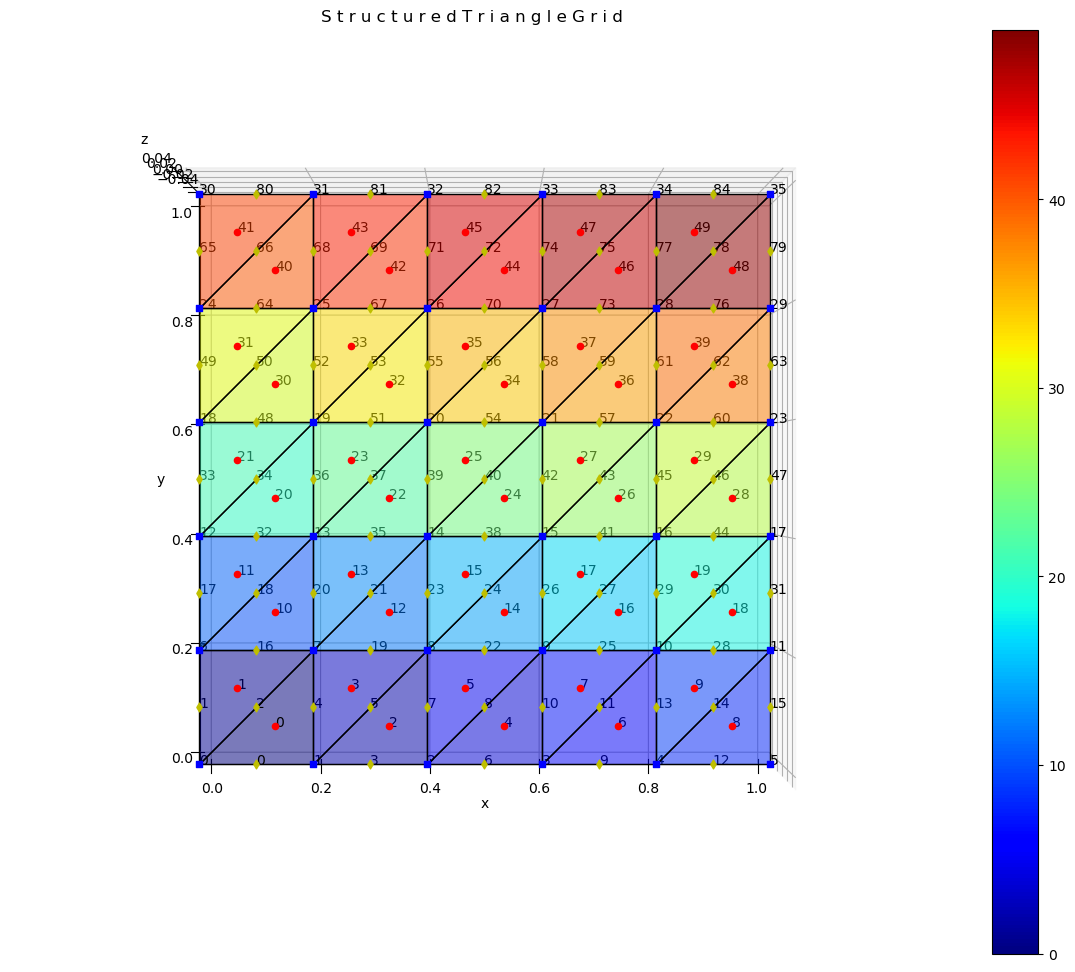

In [8]:
cell_id = np.arange(sd.num_cells)
pp.plot_grid(
    sd,
    cell_value=cell_id,
    info="cfn",
    alpha=0.5,
    figsize=(15, 12),
)

With the following code we set the data, in particular the permeability tensor and the boundary conditions. Since we need to identify each side of $\partial \Omega$ we need few steps.

In [9]:
key = "flow"

darcy_data = {}
richards_data = {}

bc_val = []
bc_ess = []
initial_pressure = []

In [10]:
q_field     = pg.RT0(key)
gamma_field = pg.Lagrange1(key)
h_field     = pg.PwConstants(key)

In [11]:
subdomain, data = mdg.subdomains(return_data=True)[0]

In [12]:
pp.initialize_data(subdomain, data, key, {
    "second_order_tensor": pp.SecondOrderTensor(np.ones(subdomain.num_cells)),
})

{'discretization_matrices': {'flow': {}},
 'parameters': Data object for physical processes flow
 The keyword "flow" has the following parameters specified: second_order_tensor}

In [13]:
# Usual BC (no slip on the left and right, fixed unitary head on the bottom. No condition on the top boundary)
left_right = np.logical_or(sd.face_centers[0, :] == 0,  sd.face_centers[0, :] == 1)

bottom = sd.face_centers[1, :] == 0

ess_p_dofs = np.zeros(h_field.ndof(sd), dtype=bool)

def h_bc(x, t): return 1
def initial_h_func(x): return 1
def infiltration(x): return 0#1e-3

bc_val = lambda t: -q_field.assemble_nat_bc(sd, lambda x: h_bc(x,t), bottom)
bc_ess.append(np.hstack((left_right, ess_p_dofs, np.zeros(N+1, dtype=bool))))

The $RT_0$ elements are constructed in such a wat that, on the non-diagonal faces, $\bm{v} \cdot \nu = 0$. Then, since $\Gamma$ is made by one of the two catheti of each boundary facing element, the only non-zero terms will be associated to the basis functions associated to the ``boundary'' cathetus. Then:

$$
\begin{bmatrix} -x \\ -y \end{bmatrix} \cdot \begin{bmatrix}-1 \\ 0 \end{bmatrix} = 0 \text{ on } \Gamma
$$

$$
\begin{bmatrix} -x \\ 1-y \end{bmatrix} \cdot \begin{bmatrix}-1 \\ 0 \end{bmatrix} = 0 \text{ on } \Gamma
$$

$$
\begin{bmatrix} x-1 \\ y \end{bmatrix} \cdot \begin{bmatrix}-1 \\ 0 \end{bmatrix} \neq 0 \text{ on } \Gamma
$$

$$
\int_0^1 \left| \bm{x}_1 - \bm{x}_0 \right| \begin{bmatrix} -1 \\ s \end{bmatrix} \cdot \begin{bmatrix}-1 \\ 0 \end{bmatrix} s ds = \int_0^1 \left| \bm{x}_1 - \bm{x}_0 \right| \begin{bmatrix} -1 \\ s \end{bmatrix} \cdot \begin{bmatrix}-1 \\ 0 \end{bmatrix} (1-s) ds = \frac{\left| \bm{x}_1 - \bm{x}_0 \right|}{2}
$$

In [14]:
def assemble_B_gamma():
    data = []
    row = []
    col = []

    # Take the x-coordinate of each face center
    faces_center_pos = sd.face_centers[0,:]

    # Look for the boundary faces ids
    index_up_face = np.where(sd.face_centers[1, :] == 1)[0]

    # Loop thorough the boundary faces
    for i in range(N):
        # s-element
        col.append(index_up_face[i])
        row.append(i)
        data.append( np.abs(faces_center_pos[i] - faces_center_pos[i+1]) / 2 )
        
        # (1-s)-element
        col.append(index_up_face[i])
        row.append(i+1)
        data.append( np.abs(faces_center_pos[i] - faces_center_pos[i+1]) / 2 )
    
    return sps.coo_matrix( (data, (row, col)), shape=(N+1, sd.num_faces) )

In [15]:
B_gamma = assemble_B_gamma()
M_gamma = gamma_field.assemble_mass_matrix( boundary_grid )
M_h = h_field.assemble_mass_matrix( subdomain )

$$
\left(
\begin{array}{cc} 
M_u(\bm{\eta_k^{n+1}}) & B^T & B_{\Gamma}\\
-\Delta t B & S_s M_h & 0\\
-\Delta t B^T_{\Gamma} & 0 & \phi M_{\Gamma}
\end{array}
\right)
\left(
\begin{array}{c} 
\bm{u^{n+1}_{k+1}}\\ 
\bm{h^{n+1}_{k+1}}\\
\bm{\eta^{n+1}_{k+1}}
\end{array}
\right)
=\left(
\begin{array}{c} 
\bm{BC}^{n+1}\\ 
\Delta t \bm{F}^{n+1} + S_s M_h \bm{h}^n\\
\phi M_{\Gamma} \bm{\eta}^n + \Delta t \bm{I}^{n+1}
\end{array}
\right)
$$

In [16]:
# B matrix
B = - pg.cell_mass(mdg, h_field) @ pg.div(mdg)

dof_p, dof_q = B.shape
dof_eta = B_gamma.shape[0]

B.shape, B_gamma.shape

((50, 85), (6, 85))

In [17]:
def vertical_projection_matrix():

    data = []
    row = []
    col = []

    for c in range(subdomain.num_cells):
        x_center = subdomain.cell_centers[:, c]
        id = np.max(np.where( boundary_grid.nodes[0, :] < x_center[0] ))

        data.append(1)
        row.append(c)
        col.append(id)

    return sps.coo_matrix( (data, (row, col)), shape=(subdomain.num_cells, boundary_grid.num_cells) )

In [18]:
cell_proj_eta = vertical_projection_matrix()

# Helper function to save the given solution to a VTU file
def save_step(sol, proj_q, proj_psi, proj_eta, saver, i):
    ins = list()

    ins.append((sd, "cell_q", ( proj_q @ sol[:dof_q] ).reshape((3, -1), order="F")))
    ins.append((sd, "cell_h", proj_psi @ sol[dof_q:(dof_q+dof_p)]))
    ins.append((sd, "cell_eta", cell_proj_eta @proj_eta @ sol[-dof_eta:]))
    # print( cell_proj_eta @ proj_eta @ sol[-1][-dof_eta:] )

    saver.write_vtu(ins, time_step=i)

In [19]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [20]:
# Initial conditions

sol = [np.zeros(dof_p + dof_q + dof_eta)]
sol[-1][dof_q:(dof_q+dof_p)] = h_field.interpolate(sd, initial_h_func)
sol[-1][-dof_eta:] = gamma_field.interpolate(boundary_grid, lambda x: 1)

In [21]:
# Prepare helper matrices

proj_q = q_field.eval_at_cell_centers(sd)
proj_psi = h_field.eval_at_cell_centers(sd)
proj_eta = gamma_field.eval_at_cell_centers(boundary_grid)

eta_diff = gamma_field.assemble_diff_matrix(boundary_grid)

In [22]:
# Save the initial solution

saver = pp.Exporter(mdg, 'sol', folder_name=output_directory)
save_step(sol[-1], proj_q, proj_psi, proj_eta, saver, 0)

In [23]:
data[pp.PARAMETERS][key].update({"second_order_tensor": pp.SecondOrderTensor(np.ones(subdomain.num_cells))})

In [24]:
# Fixed rhs
fixed_rhs = np.zeros(dof_p + dof_q + dof_eta)

In [25]:
def generate_K_func(base_height, element_height, m, ls_eta, rs_eta, grad_eta):
    scaling  = lambda x: (m+1)*(1-x)/2 - (m-1) * x / 2
    eta_func = lambda ls, rs, x: (1-x)*ls + x*rs

    eta = lambda y: eta_func(ls_eta, rs_eta, scaling(y))
    x_3 = lambda x: base_height + (1-scaling(x)) * element_height

    k11 = lambda x, y: (1 + np.power(x_3(x) * grad_eta, 2)) / eta(y)
    k12 = lambda x, y: x_3(x) * grad_eta
    k22 = lambda x, y: eta(y)

    return lambda x, y: np.array([[k11(x,y), k12(x,y)], 
                                  [k12(x,y), k22(x,y)]])

In [26]:
def local_q(coord, type, ls_eta, rs_eta, grad_eta):
    M = np.zeros(shape=(3,3))

    if type == -1:
        q_funcs = [lambda x, y: np.array([-x, 1-y]), lambda x, y:  np.array([-x, -y]), lambda x, y:  np.array([x-1, y])]
        x_2 = coord[:, 0]
        x_1 = coord[:, 2]
    else:
        q_funcs = [lambda x, y: np.array([x-1, y]) , lambda x, y:  np.array([-x, -y]), lambda x, y: np.array([-x, 1-y])]
        x_2 = coord[:, 2]
        x_1 = coord[:, 0]

    x_0 = coord[:, 1]
    vol = ( x_1[0] - x_0[0] ) * ( x_2[1] - x_0[1] ) - ( x_2[0] - x_0[0] ) * ( x_1[1] - x_0[1] )

    K_local = generate_K_func(base_height=np.min(coord[1,:]), element_height=max(np.abs(x_2[1] - x_0[1]), np.abs(x_1[1] - x_0[1])), 
                              m=type, ls_eta=ls_eta, rs_eta=rs_eta, grad_eta=grad_eta)

    for i in range(3):
        for j in range(3):
            M[i,j] = integrate.dblquad(lambda y,x: np.dot( np.dot( K_local(x, y), q_funcs[i](x,y) ), q_funcs[j](x,y)), 
                                       0, 1, 
                                       0, lambda x: 1-x)[0] * vol
    
    return M

In [29]:
def mass_q(eta_dofs):

    # Gradient of eta and pointwise value
    grad_eta   = eta_diff @ eta_dofs

    faces, cells, sign = sps.find(subdomain.cell_faces)

    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(
            subdomain, data.get("deviation_from_plane_tol", 1e-5)
        )
    
    dim = subdomain.dim
    
    node_coords = node_coords[: dim, :]

    q_field._compute_cell_face_to_opposite_node(subdomain, data)
    cell_face_to_opposite_node = data[q_field.cell_face_to_opposite_node]
    
    size_A = np.power(subdomain.dim + 1, 2) * subdomain.num_cells
    rows_A = np.empty(size_A, dtype=int)
    cols_A = np.empty(size_A, dtype=int)
    data_A = np.empty(size_A)
    idx_A = 0

    for c in range(subdomain.num_cells):
        # For the current cell retrieve its faces
        loc = slice(subdomain.cell_faces.indptr[c], subdomain.cell_faces.indptr[c + 1])
        faces_loc = faces[loc]
    
        eta_cell = np.max(np.where( boundary_grid.nodes[0, :] < sd.cell_centers[0, c] ))

        # Get the opposite node id for each face (BUGGED)
        # node = cell_face_to_opposite_node[c, :]
        node = np.flip(np.sort(cell_face_to_opposite_node[c, :]))

        #print(str(faces_loc) + ' ' + str(node))

        coord_loc = node_coords[:, node]

        A = local_q(coord_loc, 2*(faces_loc[1] - faces_loc[0])-3, eta_dofs[eta_cell], eta_dofs[eta_cell+1], grad_eta[eta_cell])

        # Save values for Hdiv-mass local matrix in the global structure
        cols = np.concatenate(faces_loc.size * [[faces_loc]])
        loc_idx = slice(idx_A, idx_A + A.size)
        rows_A[loc_idx] = cols.T.ravel()
        cols_A[loc_idx] = cols.ravel()
        data_A[loc_idx] = A.ravel()
        idx_A += A.size
    
    return sps.coo_matrix((data_A, (rows_A, cols_A)))

In [30]:
# Time Loop
for i in range(1, int(T/dt)+1):
    print('Time ' + str(i * dt))

    # Prepare the solution at the previous time step and ...
    prev = sol[-1].copy()

    # Prepare the rhs
    rhs = fixed_rhs.copy()
    rhs[:dof_q] += bc_val(i*dt)
    rhs[dof_q:(dof_q+dof_p)] += S_s / dt * M_h @ prev[dof_q:(dof_q+dof_p)]
    rhs[-dof_eta:] += (phi / dt * M_gamma @ prev[-dof_eta:] + M_gamma @ gamma_field.interpolate(boundary_grid, infiltration))

    debug_saver = pp.Exporter(mdg, str(i) + '_sol', folder_name=os.path.join(output_directory, 'debug'))
    save_step(sol[-1], proj_q, proj_psi, proj_eta, debug_saver, 0)
    
    # Non-linear loop
    for k in range(max_iterations_per_step):

        # Assemble the saddle point problem
        spp = sps.bmat([[mass_q(prev[-dof_eta:]),            B.T,          B_gamma.T], 
                        [                     -B, S_s / dt * M_h,               None],
                        [               -B_gamma,           None, phi / dt * M_gamma]], format="csc")
        
        # Prepare the solver
        ls = pg.LinearSystem(spp, rhs)
        ls.flag_ess_bc(np.hstack(bc_ess), np.zeros(dof_q + dof_p + dof_eta))

        current = ls.solve()

        # Compute the errors (with eta). Should I consider only psi? Should I compute the error on the "actual" psi values or on the dofs
        abs_err_psi  = np.sqrt(np.sum(np.power(current[dof_q:] - prev[dof_q:], 2)))
        abs_err_prev = np.sqrt(np.sum(np.power(prev[dof_q:], 2)))

        print('Iteration #' + format(k+1, '0' + str(ceil(log10(max_iterations_per_step)) + 1) + 'd') 
              + ', error L2 relative psi: ' + format(abs_err_psi, str(5 + ceil(log10(1 / abs_tol)) + 4) 
                                                     + '.' + str(ceil(log10(1 / abs_tol)) + 4) + 'f') )
        
        save_step(current, proj_q, proj_psi, proj_eta, debug_saver, k+1)

        if abs_err_psi < abs_tol + rel_tol * abs_err_prev:
            break
        else:
            prev = None
            prev = current.copy()

    print('')        

    sol.append( current.copy() )

    save_step(sol[-1], proj_q, proj_psi, proj_eta, saver, i)

saver.write_pvd([t * dt for t in range(int(T/dt)+1)])

Time 0.25
Iteration #001, error L2 relative psi:   11.1322532934


/opt/conda/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/opt/conda/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/opt/conda/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the

KeyboardInterrupt: 